# Training final model notebook

This notebook contains the process of training the final model. All assumptions in it are based on data analysis and previously performed experiments.

## Imports

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from lightgbm import LGBMRegressor

## Read data

In [154]:
df_train = pd.read_csv("./data/training.csv", sep="\t", na_values=["(null)"])
df_test = pd.read_csv("./data/validation.csv", sep="\t", na_values=["(null)"])

In [155]:
df_train.head()

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,ActualTOW,FLownPassengers,BagsCount,FlightBagsWeight
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,64016.0,175.0,61.0,440.0
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,66138.0,182.0,27.0,350.0
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,58447.0,127.0,NaN,NaN
3,01/10/2016,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,60587.0,163.0,12.0,150.0
4,01/10/2016,2016,10,1,1225,CHQ,ATH,CHQ-ATH,34,1877,63090.0,178.0,37.0,490.0


In [156]:
df_test.head()

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight
0,01/11/2016,2016,11,1,6003,MRS,BES,MRS-BES,84,3630,185.0,43.0,560.0
1,01/11/2016,2016,11,1,6004,BES,MRS,BES-MRS,86,3690,188.0,NaN,NaN
2,01/11/2016,2016,11,1,6542,MRS,STN,MRS-STN,100,4390,168.0,55.0,720.0
3,01/11/2016,2016,11,1,6541,STN,MRS,STN-MRS,100,4690,185.0,35.0,460.0
4,01/11/2016,2016,11,1,5542,STN,REU,STN-REU,112,4900,167.0,31.0,400.0


In [157]:
df_train["DepartureDate"] = df_train["DepartureDate"].astype("datetime64[us]")
df_test["DepartureDate"] = df_test["DepartureDate"].astype("datetime64[us]")

## Celan data

In [158]:
df_train.isnull().sum() / df_train.shape[0]

DepartureDate       0.000000
DepartureYear       0.000000
DepartureMonth      0.000000
DepartureDay        0.000000
FlightNumber        0.000000
DepartureAirport    0.000000
ArrivalAirport      0.000000
Route               0.000000
ActualFlightTime    0.000000
ActualTotalFuel     0.000000
ActualTOW           0.014564
FLownPassengers     0.003195
BagsCount           0.076822
FlightBagsWeight    0.083347
dtype: float64

In [159]:
df_test.isnull().sum() / df_test.shape[0] 

DepartureDate       0.000000
DepartureYear       0.000000
DepartureMonth      0.000000
DepartureDay        0.000000
FlightNumber        0.000000
DepartureAirport    0.000000
ArrivalAirport      0.000000
Route               0.000000
ActualFlightTime    0.000000
ActualTotalFuel     0.000000
FLownPassengers     0.004792
BagsCount           0.089457
FlightBagsWeight    0.096379
dtype: float64

In [160]:
# Delate, rows with nan in target col
df_train = df_train.dropna(subset=["ActualTOW"])

In [161]:
df_cleaned = df_train[
    (df_train["ActualFlightTime"].isna() | (df_train["ActualFlightTime"] < 1080)) &
    (df_train["ActualTotalFuel"].isna() | (df_train["ActualTotalFuel"] < 14000)) &
    (df_train["BagsCount"].isna() | (df_train["BagsCount"] < 300)) &
    (df_train["FlightBagsWeight"].isna() | (df_train["FlightBagsWeight"] < 2200))
]

In [162]:
df_cleaned.isnull().sum() / df_cleaned.shape[0]

DepartureDate       0.000000
DepartureYear       0.000000
DepartureMonth      0.000000
DepartureDay        0.000000
FlightNumber        0.000000
DepartureAirport    0.000000
ArrivalAirport      0.000000
Route               0.000000
ActualFlightTime    0.000000
ActualTotalFuel     0.000000
ActualTOW           0.000000
FLownPassengers     0.002051
BagsCount           0.074946
FlightBagsWeight    0.081474
dtype: float64

## Input data

In [122]:
df_cleaned.columns

Index(['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay',
       'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route',
       'ActualFlightTime', 'ActualTotalFuel', 'ActualTOW', 'FLownPassengers',
       'BagsCount', 'FlightBagsWeight'],
      dtype='object')

In [165]:
X_train = df_cleaned.drop(columns=['ActualTOW','DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay',
       'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route'])
y_train = df_cleaned["ActualTOW"]


X_test = df_test.drop(columns=['DepartureDate', 'DepartureYear', 'DepartureMonth', 'DepartureDay',
       'FlightNumber', 'DepartureAirport', 'ArrivalAirport', 'Route'])

In [166]:
imputer_mean = SimpleImputer(strategy="mean")
imputer = imputer_mean

X_train_inputed = imputer.fit_transform(X_train)
X_train_imputed_df = pd.DataFrame(X_train_inputed, columns=X_train.columns, index=X_train.index)

X_test_imputed = imputer.transform(X_test)
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

In [169]:
X_train_imputed_df

,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight
0,91.0,3660.0,175.0,61.000000,440.000000
1,68.0,3280.0,182.0,27.000000,350.000000
2,64.0,2720.0,127.0,45.013078,571.133757
3,35.0,1682.0,163.0,12.000000,150.000000
4,34.0,1877.0,178.0,37.000000,490.000000
...,...,...,...,...,...
29726,102.0,4880.0,177.0,96.000000,1250.000000
29727,163.0,6890.0,185.0,107.000000,1390.000000
29728,145.0,6322.0,172.0,64.000000,830.000000
29729,132.0,5880.0,183.0,82.000000,1090.000000


In [167]:
X_test_imputed_df

,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight
0,84.0,3630.0,185.0,43.000000,560.000000
1,86.0,3690.0,188.0,45.013078,571.133757
2,100.0,4390.0,168.0,55.000000,720.000000
3,100.0,4690.0,185.0,35.000000,460.000000
4,112.0,4900.0,167.0,31.000000,400.000000
...,...,...,...,...,...
1873,60.0,2775.0,173.0,12.000000,160.000000
1874,99.0,4120.0,183.0,21.000000,270.000000
1875,104.0,4230.0,182.0,31.000000,400.000000
1876,59.0,2671.0,169.0,10.000000,130.000000


## Feature Engineering

Feature Engineering Summary
To improve model performance, I created several new features based on domain logic and ratios that might better capture underlying patterns in the data. These features fall into several categories:

1. Payload-Related Features
* `Average Bag Weight per Bag`: Calculates average weight per piece of luggage.

* `Bags per Passenger`: Estimates how many bags are associated with each passenger.

* `TotalPassengerBagItems`: Sum of flown passengers and bags to represent total onboard items.

2. Fuel Efficiency & Consumption Ratios
* `Fuel per Passenger`: Measures how much fuel is used per passenger.

* `Fuel per Flight Minute`: Indicates fuel efficiency over time.

* `Fuel per Bag Weight Unit`: Captures fuel use relative to total baggage weight.

3. Flight Characteristics & Interactions
* `FlightTime × Passengers`: Captures interaction between flight duration and number of passengers, potentially useful for understanding total transport workload.

4. Polynomial Features
Squared terms for key features (ActualTotalFuel, ActualFlightTime, FLownPassengers, FlightBagsWeight) to help the model capture potential non-linear relationships.

5. Payload & Fuel Ratios
* `EstimatedPayloadWeight`: Combines estimated passenger weight (assuming 70 kg per person) with baggage weight.

* `Fuel to Payload Ratio`: Measures how much fuel is used relative to the total estimated payload.

* `Flight Time per Unit of Fuel`: Reflects operational efficiency in terms of how long the aircraft can fly per fuel unit.

In [ ]:
def create_new_features(df_input):
    df = df_input.copy()


    # --- 1. Payload-Related Features ---
    # Average Bag Weight per Bag
    df['AvgBagWeightPerBag'] = np.where(
        df['BagsCount'] > 0,
        df['FlightBagsWeight'] / df['BagsCount'],
        0 
    )

    # Bags per Passenger
    df['BagsPerPassenger'] = np.where(
        df['FLownPassengers'] > 0,
        df['BagsCount'] / df['FLownPassengers'],
        0 
    )

    # Total items (passengers + bags)
    df['TotalPassengerBagItems'] = df['FLownPassengers'] + df['BagsCount']

    # --- 2. Fuel Efficiency / Consumption Ratios ---
    # Fuel per Passenger
    df['FuelPerPassenger'] = np.where(
        df['FLownPassengers'] > 0,
        df['ActualTotalFuel'] / df['FLownPassengers'],
        0 
    )

    # Fuel per Flight Minute
    # ActualFlightTime is likely in minutes.
    df['FuelPerFlightMinute'] = np.where(
        df['ActualFlightTime'] > 0,
        df['ActualTotalFuel'] / df['ActualFlightTime'],
        0 
    )

    # Fuel per Bag Weight
    df['FuelPerBagWeightUnit'] = np.where(
        df['FlightBagsWeight'] > 0,
        df['ActualTotalFuel'] / df['FlightBagsWeight'],
        0 
    )

    # --- 3. Flight Characteristics & Interactions ---
    # Interaction: Flight Time and Passengers
    df['FlightTime_x_Passengers'] = df['ActualFlightTime'] * df['FLownPassengers']


    # --- 4. Polynomial Features (for potentially non-linear relationships) ---
    df['ActualTotalFuel_sq'] = df['ActualTotalFuel']**2
    df['ActualFlightTime_sq'] = df['ActualFlightTime']**2
    df['FLownPassengers'] = df['FLownPassengers']**2
    df['FlightBagsWeight_sq'] = df['FlightBagsWeight']**2


    # --- Derived feature related to payload and fuel ---
    AVG_PASSENGER_WEIGHT_KG = 70 # This is an arbitrary assumption
    df['EstimatedPayloadWeight'] = (df['FLownPassengers'] * AVG_PASSENGER_WEIGHT_KG) + df['FlightBagsWeight']

    # Ratio of Fuel to Estimated Payload
    df['FuelToPayloadRatio'] = np.where(
        df['EstimatedPayloadWeight'] > 0,
        df['ActualTotalFuel'] / df['EstimatedPayloadWeight'],
        0 
    )


    # Ratio of flight time to fuel
    df['FlightTimePerFuelUnit'] = np.where(
        df['ActualTotalFuel'] > 0,
        df['ActualFlightTime'] / df['ActualTotalFuel'],
        0
    )


    return df

In [171]:
X_train_final = create_new_features(X_train_imputed_df)
X_test_final = create_new_features(X_test_imputed_df)

In [ ]:
# df_cleaned['DayOfWeek'] = df_cleaned['DepartureDate'].dt.dayofweek
# df_cleaned['IsWeekend'] = df_cleaned['DayOfWeek'].isin([5, 6]).astype(int)

# df_test['DayOfWeek'] = df_test['DepartureDate'].dt.dayofweek
# df_test['IsWeekend'] = df_test['DayOfWeek'].isin([5, 6]).astype(int)


# X_train_final['DayOfWeek'] = df_cleaned['DayOfWeek']
# X_train_final['IsWeekend'] = df_cleaned['IsWeekend']

# X_test_final['DayOfWeek'] = df_test['DayOfWeek']
# X_test_final['IsWeekend'] = df_test['IsWeekend']


/tmp/ipykernel_40386/3855912211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['DayOfWeek'] = df_cleaned['DepartureDate'].dt.dayofweek
/tmp/ipykernel_40386/3855912211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['IsWeekend'] = df_cleaned['DayOfWeek'].isin([5, 6]).astype(int)


In [179]:
X_train_final

,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight,AvgBagWeightPerBag,BagsPerPassenger,TotalPassengerBagItems,FuelPerPassenger,FuelPerFlightMinute,FuelPerBagWeightUnit,FlightTime_x_Passengers,ActualTotalFuel_sq,ActualFlightTime_sq,FlightBagsWeight_sq,EstimatedPayloadWeight,FuelToPayloadRatio,FlightTimePerFuelUnit,DayOfWeek,IsWeekend
0,91.0,3660.0,30625.0,61.000000,440.000000,7.213115,0.348571,236.000000,20.914286,40.219780,8.318182,15925.0,13395600.0,8281.0,1.936000e+05,2.144190e+06,0.001707,0.024863,6,1
1,68.0,3280.0,33124.0,27.000000,350.000000,12.962963,0.148352,209.000000,18.021978,48.235294,9.371429,12376.0,10758400.0,4624.0,1.225000e+05,2.319030e+06,0.001414,0.020732,6,1
2,64.0,2720.0,16129.0,45.013078,571.133757,12.688174,0.354434,172.013078,21.417323,42.500000,4.762457,8128.0,7398400.0,4096.0,3.261938e+05,1.129601e+06,0.002408,0.023529,6,1
3,35.0,1682.0,26569.0,12.000000,150.000000,12.500000,0.073620,175.000000,10.319018,48.057143,11.213333,5705.0,2829124.0,1225.0,2.250000e+04,1.859980e+06,0.000904,0.020809,6,1
4,34.0,1877.0,31684.0,37.000000,490.000000,13.243243,0.207865,215.000000,10.544944,55.205882,3.830612,6052.0,3523129.0,1156.0,2.401000e+05,2.218370e+06,0.000846,0.018114,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29726,102.0,4880.0,31329.0,96.000000,1250.000000,13.020833,0.542373,273.000000,27.570621,47.843137,3.904000,18054.0,23814400.0,10404.0,1.562500e+06,2.194280e+06,0.002224,0.020902,5,1
29727,163.0,6890.0,34225.0,107.000000,1390.000000,12.990654,0.578378,292.000000,37.243243,42.269939,4.956835,30155.0,47472100.0,26569.0,1.932100e+06,2.397140e+06,0.002874,0.023657,5,1
29728,145.0,6322.0,29584.0,64.000000,830.000000,12.968750,0.372093,236.000000,36.755814,43.600000,7.616867,24940.0,39967684.0,21025.0,6.889000e+05,2.071710e+06,0.003052,0.022936,5,1
29729,132.0,5880.0,33489.0,82.000000,1090.000000,13.292683,0.448087,265.000000,32.131148,44.545455,5.394495,24156.0,34574400.0,17424.0,1.188100e+06,2.345320e+06,0.002507,0.022449,5,1


In [180]:
X_test_final

,ActualFlightTime,ActualTotalFuel,FLownPassengers,BagsCount,FlightBagsWeight,AvgBagWeightPerBag,BagsPerPassenger,TotalPassengerBagItems,FuelPerPassenger,FuelPerFlightMinute,FuelPerBagWeightUnit,FlightTime_x_Passengers,ActualTotalFuel_sq,ActualFlightTime_sq,FlightBagsWeight_sq,EstimatedPayloadWeight,FuelToPayloadRatio,FlightTimePerFuelUnit,DayOfWeek,IsWeekend
0,84.0,3630.0,34225.0,43.000000,560.000000,13.023256,0.232432,228.000000,19.621622,43.214286,6.482143,15540.0,13176900.0,7056.0,313600.000000,2.396310e+06,0.001515,0.023140,0,0
1,86.0,3690.0,35344.0,45.013078,571.133757,12.688174,0.239431,233.013078,19.627660,42.906977,6.460833,16168.0,13616100.0,7396.0,326193.768942,2.474651e+06,0.001491,0.023306,0,0
2,100.0,4390.0,28224.0,55.000000,720.000000,13.090909,0.327381,223.000000,26.130952,43.900000,6.097222,16800.0,19272100.0,10000.0,518400.000000,1.976400e+06,0.002221,0.022779,0,0
3,100.0,4690.0,34225.0,35.000000,460.000000,13.142857,0.189189,220.000000,25.351351,46.900000,10.195652,18500.0,21996100.0,10000.0,211600.000000,2.396210e+06,0.001957,0.021322,0,0
4,112.0,4900.0,27889.0,31.000000,400.000000,12.903226,0.185629,198.000000,29.341317,43.750000,12.250000,18704.0,24010000.0,12544.0,160000.000000,1.952630e+06,0.002509,0.022857,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,60.0,2775.0,29929.0,12.000000,160.000000,13.333333,0.069364,185.000000,16.040462,46.250000,17.343750,10380.0,7700625.0,3600.0,25600.000000,2.095190e+06,0.001324,0.021622,0,0
1874,99.0,4120.0,33489.0,21.000000,270.000000,12.857143,0.114754,204.000000,22.513661,41.616162,15.259259,18117.0,16974400.0,9801.0,72900.000000,2.344500e+06,0.001757,0.024029,0,0
1875,104.0,4230.0,33124.0,31.000000,400.000000,12.903226,0.170330,213.000000,23.241758,40.673077,10.575000,18928.0,17892900.0,10816.0,160000.000000,2.319080e+06,0.001824,0.024586,0,0
1876,59.0,2671.0,28561.0,10.000000,130.000000,13.000000,0.059172,179.000000,15.804734,45.271186,20.546154,9971.0,7134241.0,3481.0,16900.000000,1.999400e+06,0.001336,0.022089,0,0


## Cross Validation

In [ ]:
cols_to_drop = ["ActualFlightTime_sq", "ActualFlightTime"]

In [187]:
# 📌 Scorery
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# 📌 VotingRegressor (ensemble)
ensemble_model = VotingRegressor([
    ("rf", RandomForestRegressor(random_state=42)),
    ("lgbm", LGBMRegressor(random_state=42))
])


# 📌 Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 📊 Cross-val wyniki
rmse_scores = cross_val_score(ensemble_model, X_train_final.drop(columns=cols_to_drop), y_train, cv=cv, scoring=rmse_scorer)
r2_scores = cross_val_score(ensemble_model, X_train_final, y_train, cv=cv, scoring=r2_scorer)

# Zmiana znaku RMSE (bo cross_val_score go neguje)
rmse_scores = -rmse_scores

# 📋 DataFrame wyników
results_df = pd.DataFrame({
    "Fold": list(range(1, 6)),
    "RMSE": rmse_scores,
    "R2 Score": r2_scores
})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3872
[LightGBM] [Info] Number of data points in the train set: 23408, number of used features: 16
[LightGBM] [Info] Start training from score 65034.165328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3872
[LightGBM] [Info] Number of data points in the train set: 23409, number of used features: 16
[LightGBM] [Info] Start training from score 65019.363834
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3871
[LightGBM] [Info] Number of data points in the t

In [ ]:
rmse_scores.mean() 

930.5399947990461

/tmp/ipykernel_40386/3458663403.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=results_df, x="Fold", y="RMSE", size=12, palette="Blues", ax=axes[0])
/tmp/ipykernel_40386/3458663403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=results_df, x="Fold", y="R2 Score", size=12, palette="Greens", ax=axes[1])


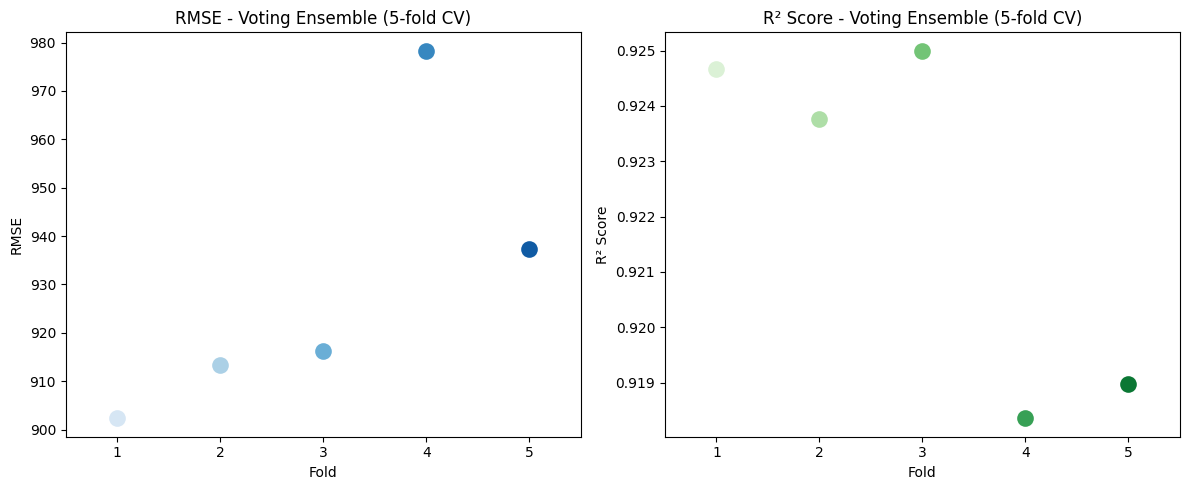

In [189]:
# 📊 Stripploty no features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.stripplot(data=results_df, x="Fold", y="RMSE", size=12, palette="Blues", ax=axes[0])
axes[0].set_title("RMSE - Voting Ensemble (5-fold CV)")
axes[0].set_xlabel("Fold")
axes[0].set_ylabel("RMSE")

sns.stripplot(data=results_df, x="Fold", y="R2 Score", size=12, palette="Greens", ax=axes[1])
axes[1].set_title("R² Score - Voting Ensemble (5-fold CV)")
axes[1].set_xlabel("Fold")
axes[1].set_ylabel("R² Score")

plt.tight_layout()
plt.show()

After several tests, the best results are given by the current combination of features
Of course, it is still possible to optimize hyperparameters, which should allow better results, however, for this problem I will skip it. 

## Train Final Model

As previous tests showed the best models were Random Forest and LGBM so I decided to combine these models into one ensemble 

In [ ]:
ensemble_model = VotingRegressor([
    ("rf", RandomForestRegressor(random_state=42)),
    ("lgbm", LGBMRegressor(random_state=42))
])

ensemble_model.fit(X_train_final.drop(columns=cols_to_drop), y_train)

y_pred = ensemble_model.predict(X_test_final.drop(columns=cols_to_drop))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 29261, number of used features: 16
[LightGBM] [Info] Start training from score 65028.656232


## Save final results

In [194]:
submission_df = pd.DataFrame({
    "Id": X_test_final.index,  
    "Prediction": y_pred
})


submission_df.to_csv("./predictions/predictions.csv", index=False)

In [ ]:
df_test_with_predictions = df_test.copy()
df_test_with_predictions["Prediction"] = y_pred
df_test_with_predictions.to_csv("./predictions/test_with_predictions.csv", index=False)